# Exercise 06
# TensorFlow and Keras
###### Aleksey Sepulveda Dúran and Jose Eduardo Sandoval
---

## Data preparation

In [12]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

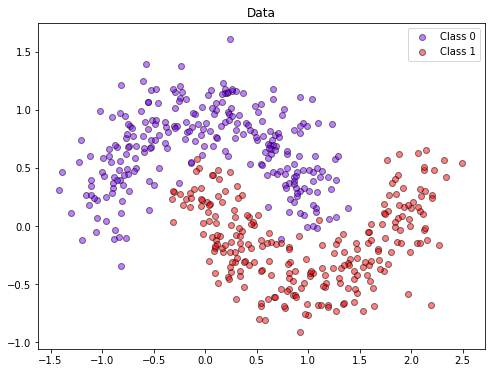

In [13]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

### Library Import

In [18]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs


%matplotlib inline

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

## Definition Model

In [19]:
####Graph NeuralNet

numN = 10
graph = tf.Graph()

with graph.as_default():    
    #Entrada:
    x = tf.placeholder(tf.float32,shape=[None,2]) 
    y_true = tf.placeholder(tf.float32,shape=None) 
    
    with tf.name_scope('hidden_layer') as scope: 
        w_1 = tf.Variable(tf.random_normal([numN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([numN,1]),dtype=tf.float32,name='bias1') 
   
        h = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) + b1, name='sigmoid')
   
    #lAYER1 
    with tf.name_scope('inference') as scope:
        w_2 = tf.Variable(tf.random_normal([1,numN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w_2,h) + b )

    #LOSS FUNCTION
    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss) 
  
    #OPTIMIZER
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
show_graph(graph.as_graph_def())

### Loss Function
#### The evolution of the training and test loss.

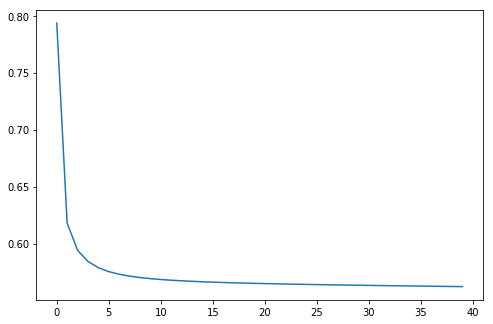

In [20]:
epoch = 2000
losses = []

with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(epoch):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train})) 
                       
pl.figure(figsize = (8,16/3)) 
pl.plot(losses)

### Prediction

[[ 0.01065977  1.2166839 ]
 [ 0.8763801  -1.9591373 ]
 [-1.9755557  -1.6914784 ]
 [ 0.95951486 -1.7952118 ]
 [ 0.97055364 -3.2147408 ]
 [-0.77083355  0.40715832]
 [-0.532502    2.7630885 ]
 [-0.9231953   3.293439  ]
 [-0.46944895  2.2300556 ]
 [-0.765531    2.1791866 ]]
[[8.596298e-06]]


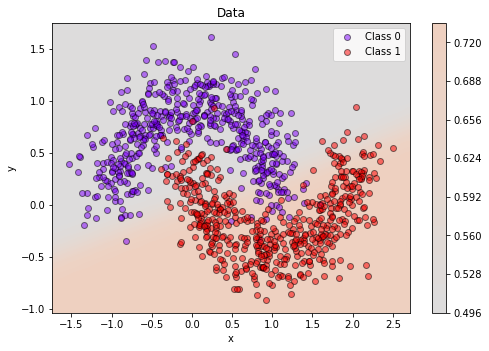

In [21]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w_1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


In [56]:
import keras
import numpy as np
import pylab as pl
import keras.optimizers as opts
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.datasets.samples_generator import make_moons
from keras.optimizers import SGD
from livelossplot import PlotLossesKeras

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')


Loading data...
8982 train sequences
2246 test sequences
46 classes


In [57]:
print(x_train[101])

[1, 2, 149, 8, 25, 2, 400, 304, 200, 6, 337, 4, 342, 2, 2, 7, 2, 2, 9, 4, 342, 643, 2, 7, 2, 4, 88, 2, 31, 4, 384, 292, 211, 5, 2, 978, 220, 33, 851, 2, 11, 15, 9, 447, 7, 42, 92, 131, 276, 5, 156, 11, 15, 50, 33, 30, 2, 7, 2, 383, 29, 336, 25, 383, 29, 2, 94, 156, 4, 49, 8, 7, 788, 4, 88, 33, 2, 747, 11, 15, 197, 92, 222, 825, 5, 934, 11, 15, 2, 8, 17, 12]


In [58]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


In [59]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


In [60]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


### Calibration

In [61]:
batch = 20
epoch = 20

### With Softmax Activation

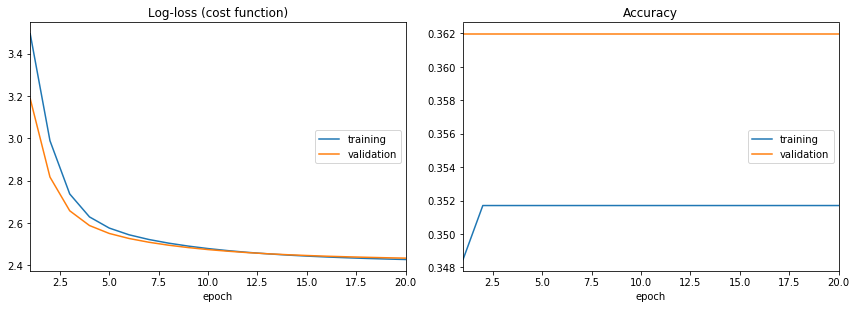

2246/2246 [==============================] - 0s 66us/step
Test score: 2.433676419253872
Test accuracy: 0.36197684778237277


In [62]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='softmax'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Elu Activation

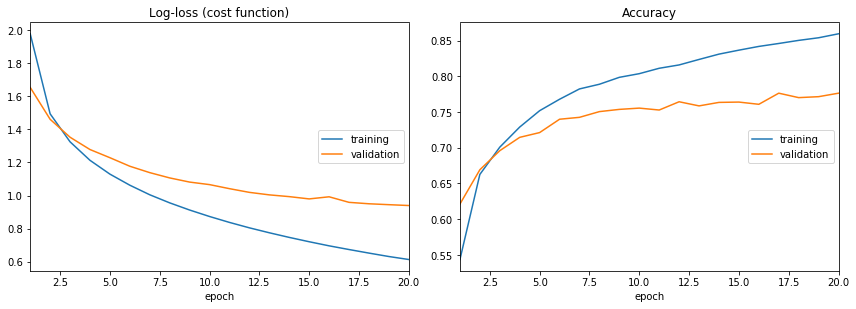

2246/2246 [==============================] - 0s 59us/step
Test score: 0.9397480449608576
Test accuracy: 0.7764915405164737


In [63]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='elu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Selu Activation

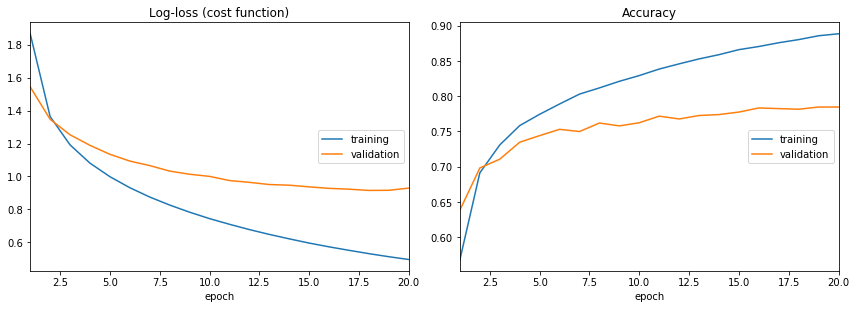

2246/2246 [==============================] - 0s 46us/step
Test score: 0.9292197717902709
Test accuracy: 0.784505788094214


In [64]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Softplus Activation

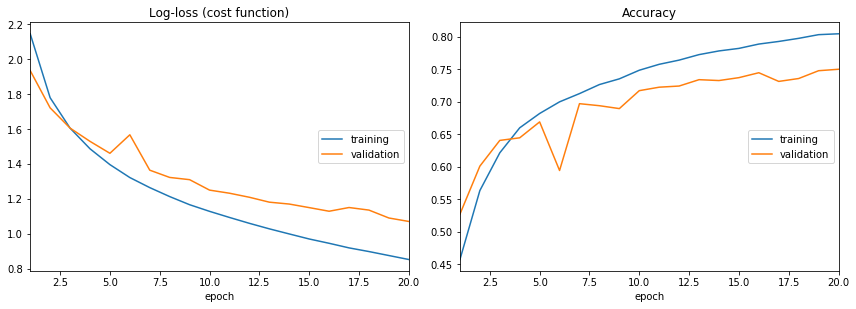

2246/2246 [==============================] - 0s 45us/step
Test score: 1.0696887519883982
Test accuracy: 0.7497773820124666


In [65]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='softplus'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With hard_sigmoid Activation

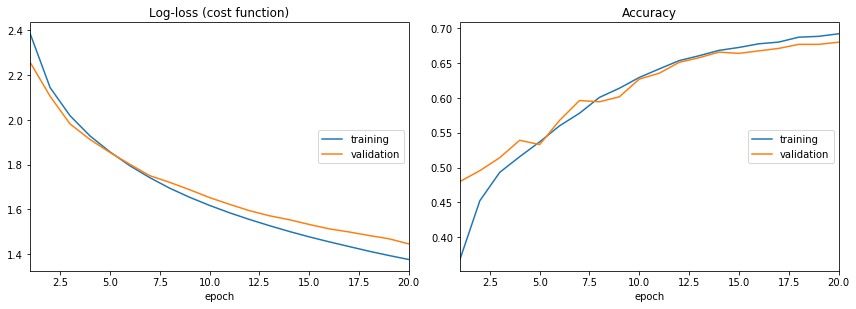

2246/2246 [==============================] - 0s 44us/step
Test score: 1.4460524228249718
Test accuracy: 0.6798753339535194


In [66]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='hard_sigmoid'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Modifier Optimizers

### With Optimizer RMSprop

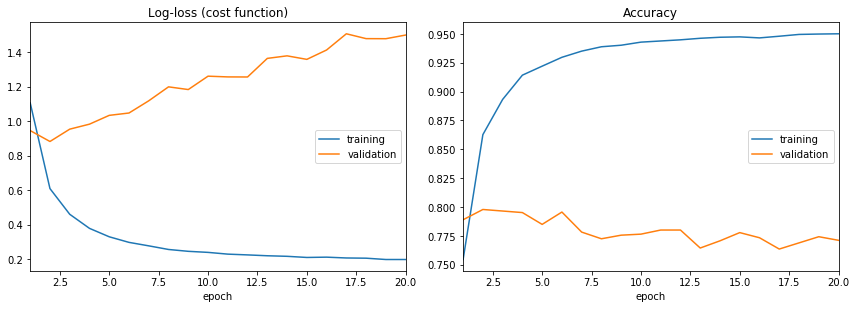

2246/2246 [==============================] - 0s 45us/step
Test score: 1.500365965300549
Test accuracy: 0.7711487088687485


In [67]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=opts.RMSprop(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Optimizer Adagrad

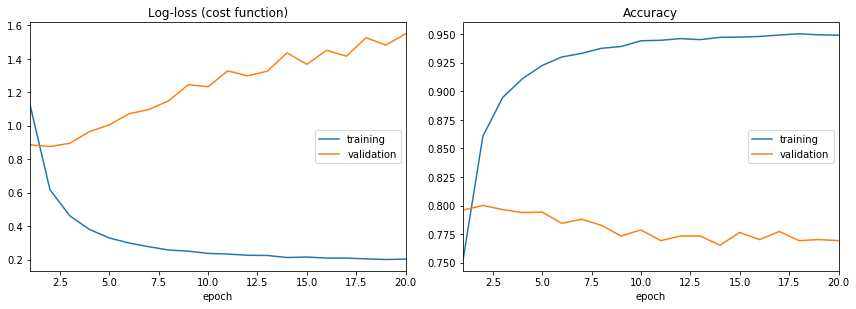

2246/2246 [==============================] - 0s 46us/step
Test score: 1.5496855548525748
Test accuracy: 0.7693677649684815


In [68]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=opts.RMSprop(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Optimizer Adadelta

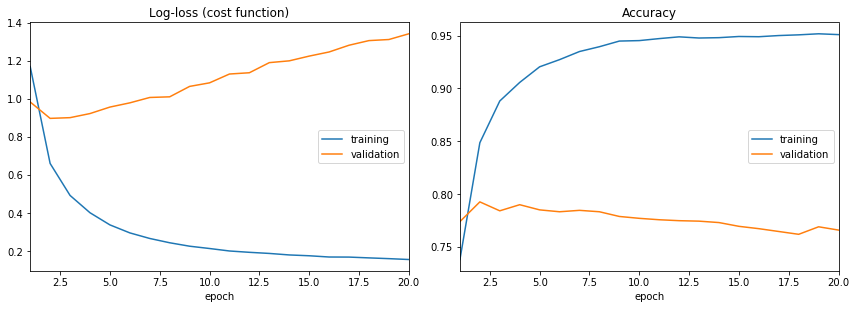

2246/2246 [==============================] - 0s 46us/step
Test score: 1.3407898399305471
Test accuracy: 0.7658058771679471


In [70]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=opts.Adadelta(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Optimizer Nadam

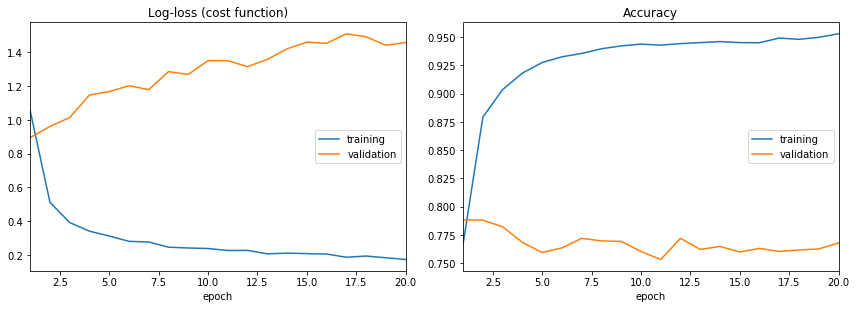

2246/2246 [==============================] - 0s 47us/step
Test score: 1.4587265871936257
Test accuracy: 0.768032057043281


In [72]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=opts.Nadam(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### With Optimizer Adam

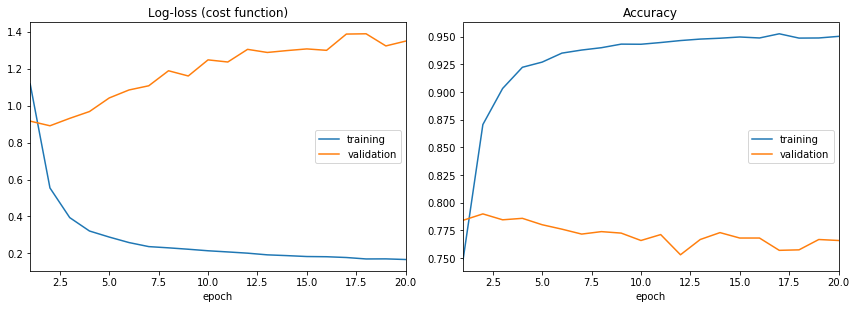

2246/2246 [==============================] - 0s 56us/step
Test score: 1.3485120748263433
Test accuracy: 0.7658058771679471


In [82]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=opts.Adam(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## With DropOut

### DropOut 0.3

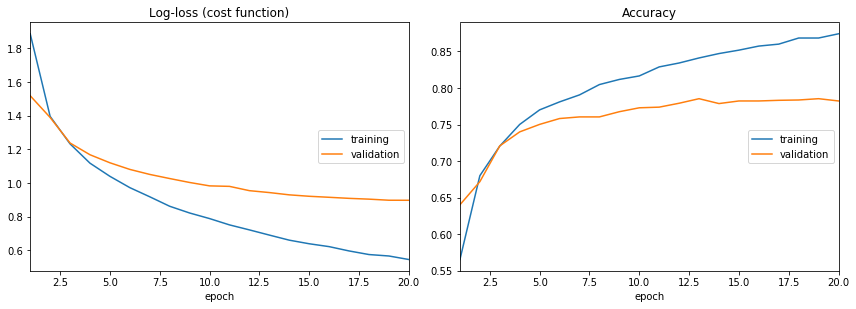

2246/2246 [==============================] - 0s 52us/step
Test score: 0.8977934592341272
Test accuracy: 0.7822796082454182


In [84]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Dropout 0.5

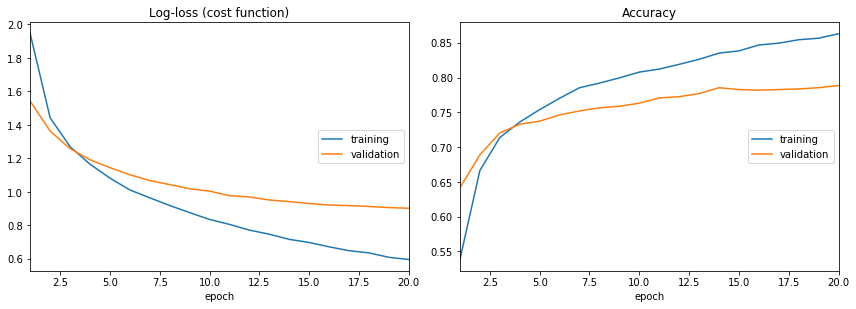

2246/2246 [==============================] - 0s 50us/step
Test score: 0.9018560103402006
Test accuracy: 0.788512911843277


In [85]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,), activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## With Diferent Initializer

In [91]:
### Intilializer random_uniform

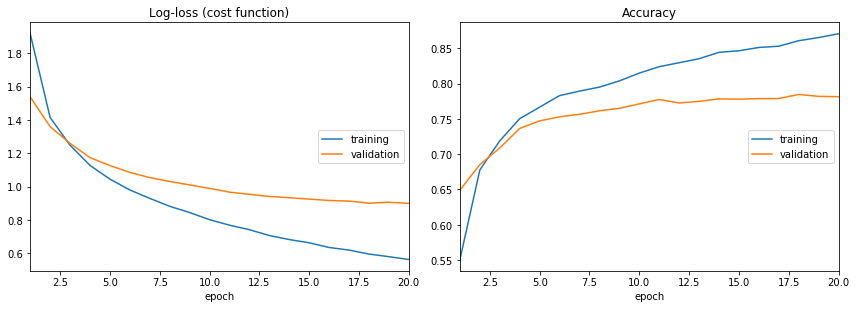

2246/2246 [==============================] - 0s 54us/step
Test score: 0.9008039997182355
Test accuracy: 0.7813891362952846


In [90]:
keras.initializers.Zeros()
model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer= 'random_uniform', activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Intilializer random_normal

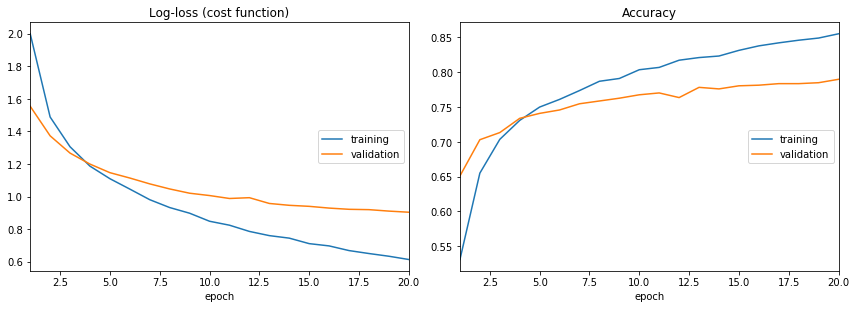

2246/2246 [==============================] - 0s 50us/step
Test score: 0.9040732347636168
Test accuracy: 0.7898486198215535


In [92]:

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer= 'random_normal', activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
#model.summary(70)
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

Score = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epoch,
                    verbose=1,
                    validation_data = [x_test,y_test],callbacks=[PlotLossesKeras()])

score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

#####  With all the modifications made. The conclusion is obtained that the best method to improve the network is with the combination: Activation Selu, Initializer Ramdon Normal, Drop Out 0.5 and Optimizer SGD. This taking into account the best precision and its behavior, throughout the Epoch.